In [1]:
####### Mouting Drive #######
from google.colab import drive
drive.mount('/content/drive')
!ls

Mounted at /content/drive
drive  sample_data


In [3]:
!unzip "/content/datasets_zip/dataset.zip"

Archive:  /content/datasets_zip/dataset.zip
   creating: dataset/
   creating: dataset/a/
  inflating: dataset/a/hand1_a_bot_seg_1_cropped.jpeg  
  inflating: dataset/a/hand1_a_bot_seg_2_cropped.jpeg  
  inflating: dataset/a/hand1_a_bot_seg_3_cropped.jpeg  
  inflating: dataset/a/hand1_a_bot_seg_4_cropped.jpeg  
  inflating: dataset/a/hand1_a_bot_seg_5_cropped.jpeg  
  inflating: dataset/a/hand1_a_dif_seg_1_cropped.jpeg  
  inflating: dataset/a/hand1_a_dif_seg_2_cropped.jpeg  
  inflating: dataset/a/hand1_a_dif_seg_3_cropped.jpeg  
  inflating: dataset/a/hand1_a_dif_seg_4_cropped.jpeg  
  inflating: dataset/a/hand1_a_dif_seg_5_cropped.jpeg  
  inflating: dataset/a/hand1_a_left_seg_1_cropped.jpeg  
  inflating: dataset/a/hand1_a_left_seg_2_cropped.jpeg  
  inflating: dataset/a/hand1_a_left_seg_3_cropped.jpeg  
  inflating: dataset/a/hand1_a_left_seg_4_cropped.jpeg  
  inflating: dataset/a/hand1_a_left_seg_5_cropped.jpeg  
  inflating: dataset/a/hand1_a_right_seg_1_cropped.jpeg  
  infla

In [4]:
import os
os.chdir("/content/dataset")

In [5]:
!pip install patchify


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
!pip install vit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.4/95.4 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 634.6/634.6 kB 36.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for tasklib: filename=tasklib-2.5.1-py3-none-any.whl size=25485 sha256=6df6043c2e4c2bed3b297d03a9bc89868c2b8781cc49d74b734fd467398cb1e1
  Stored in directory: /root/.cache/pip/wheels/96/24/3e/8af6cb4e6abcb4a45d003b975c52c0dbd843a0a6a3f6f0a07c
  Created wheel for urwid: filename=urwid-2.1.2-cp39-cp39-linux_x86_64.whl size=259623 sha256=4ca6882a743c6eb8367a73a35fccd4436d8032bfd736cf6b390bcdba5c0d5f5c
  Stored in directory: /root/.cache/pip/wheels/44/ec/04/2c1080c3ee4e80e76d662ac35f0594a2a86f9df12095b05cb3
Successfully built tasklib urwid


In [ ]:
# !unzip "/content/drive/MyDrive/Colab Notebooks/Updated/datasets_zip/dataset.zip"

In [8]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from patchify import patchify
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping
from vit import ViT

#""" Hyperparameters """

In [9]:
hp = {}
hp["image_size"] = 200
hp["num_channels"] = 3
hp["patch_size"] = 25
hp["num_patches"] = (hp["image_size"]**2) // (hp["patch_size"]**2)
hp["flat_patches_shape"] = (hp["num_patches"], hp["patch_size"]*hp["patch_size"]*hp["num_channels"])

In [10]:
hp["batch_size"] = 32
hp["lr"] = 1e-4
hp["num_epochs"] = 50
hp["num_classes"] = 26
hp["class_names"] = ["a", "b", "c", "d", "e","f","g","h","i","j","k","l","m","n","o","p","q","r","s","t","u","v","w","x","y","z"]

In [11]:
hp["num_layers"] = 12
hp["hidden_dim"] = 768
hp["mlp_dim"] = 3072
hp["num_heads"] = 12
hp["dropout_rate"] = 0.1

In [12]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

#original code start

In [13]:
def load_data(path, split=0.1):
    images = shuffle(glob(os.path.join(path, "*", "*.jpeg")))

    split_size = int(len(images) * split)
    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)

    return train_x, valid_x, test_x

#======Seeding===============

In [14]:
def process_image_label(path):
    """ Reading images """
    path = path.decode()
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (hp["image_size"], hp["image_size"]))
    image = image/255.0
    #print(f"Image shape: {image.shape}")
    """ preprocessing to patches """
    patch_shape = (hp["patch_size"], hp["patch_size"], hp["num_channels"])
    patches = patchify(image, patch_shape, hp["patch_size"])
    #patches = np.reshape(patches, (64, 25, 25, 3))
    #for i in range(64):
      #cv2.imwrite(f"files/{i}.png", patches[i])
    patches = np.reshape(patches, hp["flat_patches_shape"])
    patches = patches.astype(np.float32)
    #=====Label=================
    class_name = path.split("/")[-2]
    class_idx = hp["class_names"].index(class_name)
    class_idx = np.array(class_idx, dtype=np.int32)

    return patches, class_idx

In [15]:
def parse(path):
    patches, labels = tf.numpy_function(process_image_label, [path], [tf.float32, tf.int32])
    labels = tf.one_hot(labels, hp["num_classes"])

    patches.set_shape(hp["flat_patches_shape"])
    labels.set_shape(hp["num_classes"])

    return patches, labels

# Data Processing

In [16]:
def tf_dataset(images, batch=64):
    ds = tf.data.Dataset.from_tensor_slices((images))
    ds = ds.map(parse).batch(batch).prefetch(8)
    return ds

In [17]:
np.random.seed(42)
tf.random.set_seed(42)
#Directory for storage files
create_dir("files")
#path
dataset_path= "/content/dataset"
model_path=os.path.join("file", "model.h5")
csv_path=os.path.join("file", "log.csv")
#dataset
train_x, valid_x, test_x = load_data(dataset_path)
print(f"Train: {len(train_x)} - Valid: {len(valid_x)} - Test: {len(test_x)}")
train_ds = tf_dataset(train_x, batch=hp["batch_size"])
valid_ds = tf_dataset(valid_x, batch=hp["batch_size"])
print("Size of train_ds", train_ds)
print("Size of train_ds", valid_ds)

Train: 1453 - Valid: 181 - Test: 181
Size of train_ds <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 1875), dtype=tf.float32, name=None), TensorSpec(shape=(None, 26), dtype=tf.float32, name=None))>
Size of train_ds <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 1875), dtype=tf.float32, name=None), TensorSpec(shape=(None, 26), dtype=tf.float32, name=None))>


In [18]:
################## Defiing Model ##############
model = ViT(hp)
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(hp["lr"], clipvalue=1.0),
    metrics=["acc"]
)

callbacks = [
    ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-10, verbose=1),
    CSVLogger(csv_path),
    EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=False),
]

In [19]:
######## Training the Model #########
model.fit(
  train_ds,
  epochs=hp["num_epochs"],
  validation_data=valid_ds,
  callbacks=callbacks
)

Epoch 1/50
46/46 [==============================] - ETA: 0s - loss: 4.4353 - acc: 0.0337
Epoch 1: val_loss improved from inf to 3.44976, saving model to file/model.h5
46/46 [==============================] - 151s 2s/step - loss: 4.4353 - acc: 0.0337 - val_loss: 3.4498 - val_acc: 0.0387 - lr: 1.0000e-04
Epoch 2/50
46/46 [==============================] - ETA: 0s - loss: 3.3454 - acc: 0.0482
Epoch 2: val_loss improved from 3.44976 to 3.30080, saving model to file/model.h5
46/46 [==============================] - 105s 2s/step - loss: 3.3454 - acc: 0.0482 - val_loss: 3.3008 - val_acc: 0.0387 - lr: 1.0000e-04
Epoch 3/50
46/46 [==============================] - ETA: 0s - loss: 2.6340 - acc: 0.1783
Epoch 3: val_loss improved from 3.30080 to 2.44116, saving model to file/model.h5
46/46 [==============================] - 107s 2s/step - loss: 2.6340 - acc: 0.1783 - val_loss: 2.4412 - val_acc: 0.2155 - lr: 1.0000e-04
Epoch 4/50
46/46 [==============================] - ETA: 0s - loss: 1.9295 - acc

In [50]:

import seaborn as sns
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


1/1 [==============================] - 0s 402ms/step


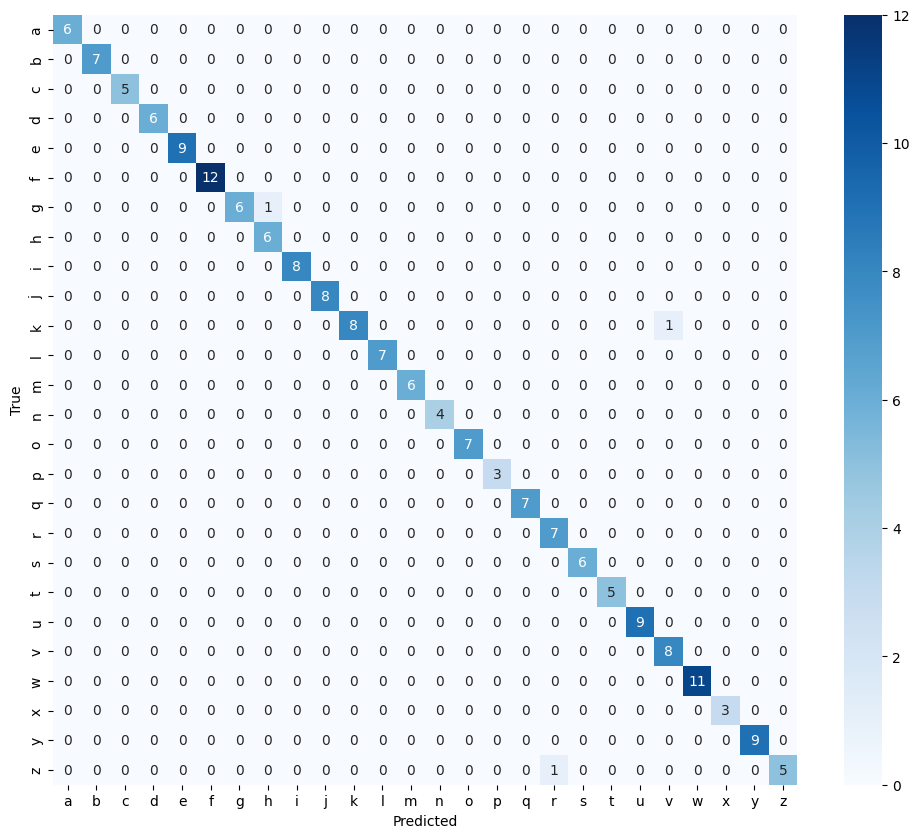

              precision    recall  f1-score   support

           a     1.0000    1.0000    1.0000         6
           b     1.0000    1.0000    1.0000         7
           c     1.0000    1.0000    1.0000         5
           d     1.0000    1.0000    1.0000         6
           e     1.0000    1.0000    1.0000         9
           f     1.0000    1.0000    1.0000        12
           g     1.0000    0.8571    0.9231         7
           h     0.8571    1.0000    0.9231         6
           i     1.0000    1.0000    1.0000         8
           j     1.0000    1.0000    1.0000         8
           k     1.0000    0.8889    0.9412         9
           l     1.0000    1.0000    1.0000         7
           m     1.0000    1.0000    1.0000         6
           n     1.0000    1.0000    1.0000         4
           o     1.0000    1.0000    1.0000         7
           p     1.0000    1.0000    1.0000         3
           q     1.0000    1.0000    1.0000         7
           r     0.8750    

In [47]:
# Load the best model
best_model = model

# Prepare the test dataset
test_ds = tf_dataset(test_x, batch=hp["batch_size"])

# Make predictions on the test dataset
y_pred = []
y_true = []
for x, y in test_ds:
    predictions = best_model.predict(x)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(np.argmax(y.numpy(), axis=1))

y_pred_classes = np.array(y_pred)
y_true = np.array(y_true)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=hp["class_names"], yticklabels=hp["class_names"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Calculate precision, recall, and sensitivity (recall)
report = classification_report(y_true, y_pred_classes, target_names=hp["class_names"], digits=4)
print(report)


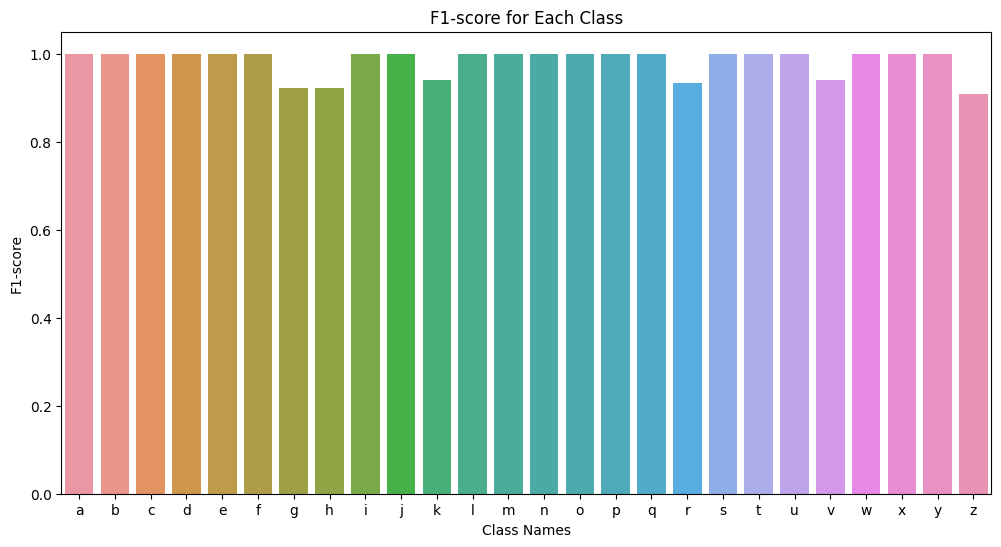

In [49]:
# Calculate precision, recall, and sensitivity (recall)
report = classification_report(y_true, y_pred_classes, target_names=hp["class_names"], digits=4, output_dict=True)

# Extract F1-scores from the report
f1_scores = []
for class_name in hp["class_names"]:
    f1_scores.append(report[class_name]['f1-score'])

# Plot the F1-scores using a bar chart with Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x=hp["class_names"], y=f1_scores)
plt.xlabel("Class Names")
plt.ylabel("F1-score")
plt.title("F1-score for Each Class")
plt.show()


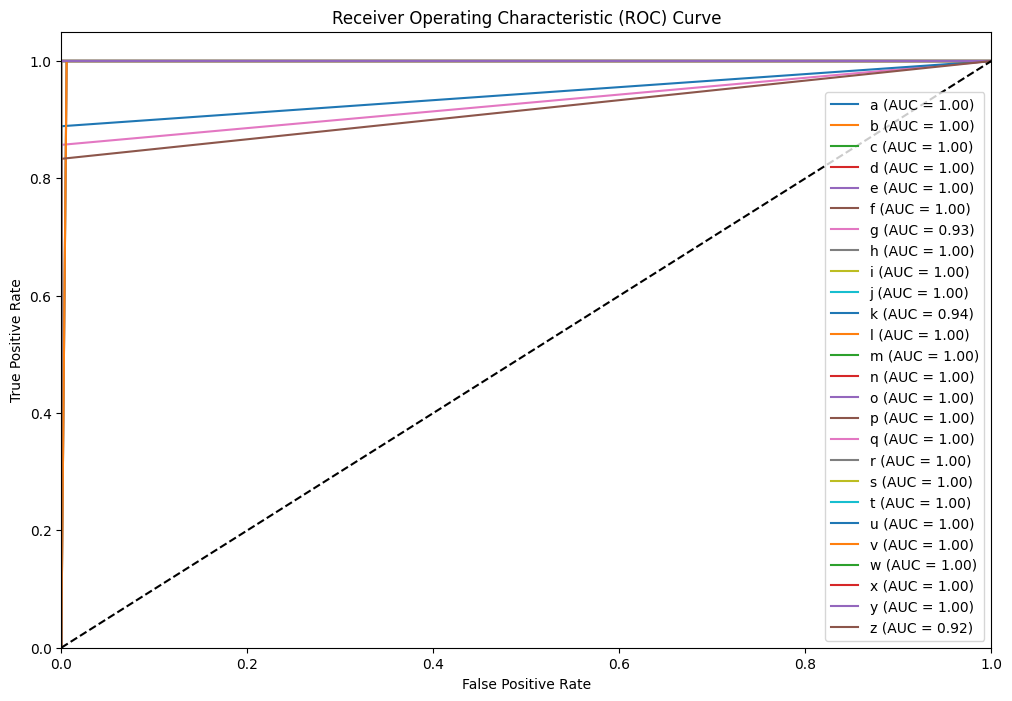

In [52]:
# Binarize the true labels
y_true_binarized = label_binarize(y_true, classes=list(range(hp["num_classes"])))

# Binarize the predicted labels
y_pred_binarized = label_binarize(y_pred_classes, classes=list(range(hp["num_classes"])))

# Calculate the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(hp["num_classes"]):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_binarized[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure(figsize=(12, 8))
for i, class_name in enumerate(hp["class_names"]):
    plt.plot(fpr[i], tpr[i], label=f'{class_name} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
